### 0.导入函数库

In [1]:
%matplotlib inline
from obspy.core import read
from obspy.signal.invsim import cosine_taper 
from obspy.signal.filter import lowpass
from obspy.core import UTCDateTime
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 12, 10

### 1.傅里叶变换

创建一个频率为4 Hz、采样率为100Hz的正弦波，通过FFT将其转换到频域并绘制两者。
```
1) 由于信号是由单一频率产生的，我们应该在该频率的图中得到一个delta脉冲。相反，我们得到了一个三角形，表明部分能量/幅度分布在4Hz的中心频率附近。这就是所谓的频谱泄漏，即中心频率的“模糊”。原因在于傅里叶变换，它假设信号是无限的。信号的有限长度限制了频率间距：Δf=1/T。
2) 时域信号越长，频率峰值越明显。时域中长信号意味着频域中的良好分辨率，反之亦然。这也被称为不确定性原理。
3) 通过在时域中对信号进行零填充（即在信号的开头和结尾添加幅度为零的额外样本）来人为地增加信号的长度。因此，我们不是添加信息（其他频率），而只是增加信号的长度，从而提高频率分辨率。
```

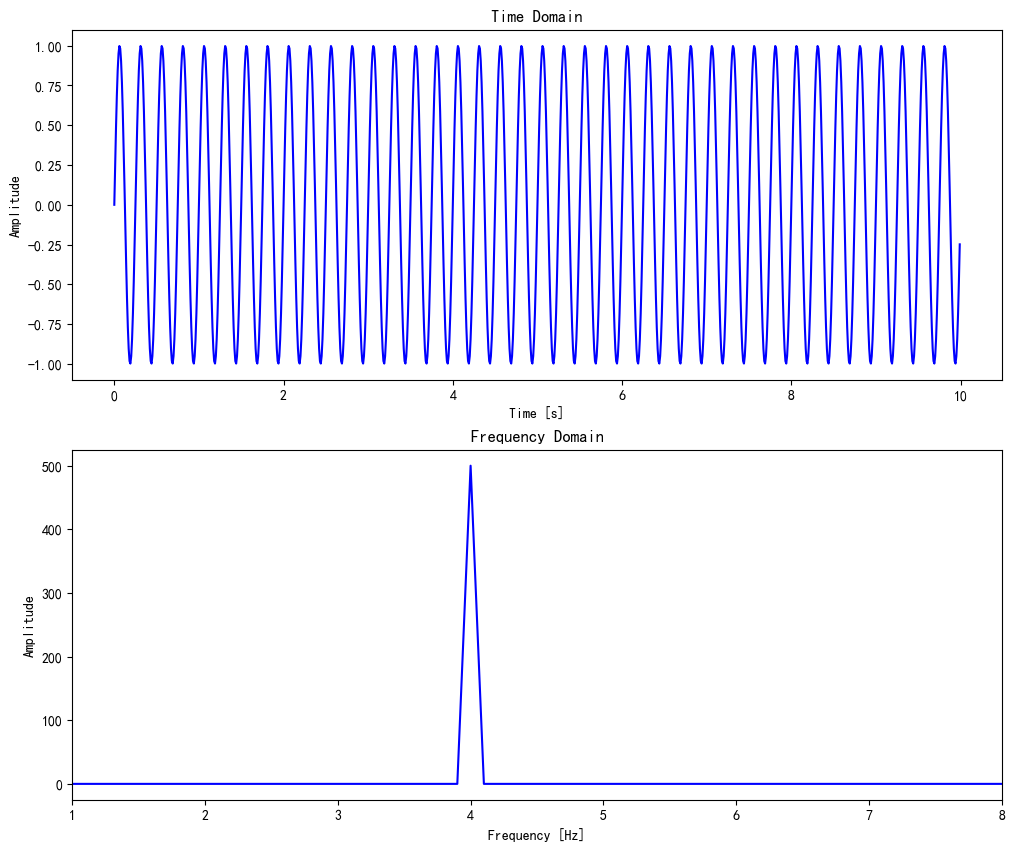

In [2]:
# leng = 5.0
leng = 10.0                                 # 信号长度（以秒为单位，初始值：2秒
dt = 1./100.                                # 采样间隔
ny = 1/dt/2.                                # 奈奎斯特频率
t = np.arange(0, leng, dt)                  # 时间轴
gen_single  = np.sin(2 * 4 * np.pi * t)     # 生成一个正弦波作为信号

Fsin = np.fft.rfft(gen_single)              # 信号通过FFT转换到频域
f = np.linspace(0, ny, len(Fsin))           # 频率轴

# 绘图
plt.subplot(211)
plt.plot(t, gen_single, 'b')
plt.title('Time Domain')
plt.ylim(-1.1,1.1)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(212)
plt.plot(f, abs(Fsin), 'b')
plt.xlim(1,8)
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

### 2.奈奎斯特频率与混叠
在数字世界中，我们既没有连续信号也没有周期信号。我们总是处理采样信号。因此，我们需要定义一些描述采样的术语：
采样间隔是单个采样值之间的时间距离Δt。信号中一个采样k在时间轴上的位置因此表示为t=kΔt，其中k=[1,2,...,N]，N是信号中的最大采样数。
信号周期由T=NΔt给出。采样率也称为采样频率，是Δf=1/T。
采样定理指出，为了正确重现信号的最高频率，每个周期至少需要2个采样。换句话说：只有当信号不包含高于采样频率一半的频率分量时，才能正确地重现信号。这就是奈奎斯特频率的定义：

fre_nyq=1/(2Δt)=Δf/2

这个定理的一个重要推论是，在将数据重新采样到较低的采样率之前，有必要对其进行低通滤波处理。低通滤波器的截止频率最大为新采样率的奈奎斯特频率。如果不考虑这个必要性，就会有混叠效应。当处理谱分析时，应该清楚，它基本上是基于傅里叶级数/傅里叶变换的特性和属性。

在下面的单元格中，我们首先创建一个由两个不同频率（4 Hz和8 Hz）组成的信号，并以20 Hz的采样率进行采样（蓝色）。然后，我们以两种方式将其降采样至10 Hz：首先，我们只是降低采样率（红色）；其次，在降采样之前，我们对数据进行低通滤波（绿色）。最后，将所有三种信号在时域和频域中绘制出来，以观察其效果。

```
1） 原始的奈奎斯特频率是10 Hz。新的频率是5 Hz。
2） 在时域中，下采样信号（红色）的周期性更长（低频），但最大幅度保持不变。在频域中，原始数据显示在4Hz和8Hz处有两个峰值，这是用于创建信号的发生器频率。下采样数据也显示了两个峰值，但分别位于2Hz和4Hz，幅度要小得多。8Hz的峰值无法再分辨出来，因为它高于新的奈奎斯特频率5Hz。由于在下采样之前没有从数据中去除8Hz的能量，所以它被“映射”到了2Hz的错误频率。我们还失去了8Hz峰值的能量/幅度。因此，2Hz峰值的错误频率受到4Hz峰值的“供给”。因此，我们无法解析4Hz峰值的完整幅度。我们不仅扭曲了信号的频率内容，还扭曲了幅度。这种效应叫做混叠。在实际数据中无法区分这个错误，而且无法逆转。一旦您在低通滤波之前对数据进行了下采样，它们就会被破坏，您甚至都不会意识到。这可能导致完全错误的解释。
3） 我们已经去除了高于新奈奎斯特频率的所有能量。因此，在频域中，我们只能看到剩下的原始频率4Hz处的一个峰值，其幅度完全保持原样。
```

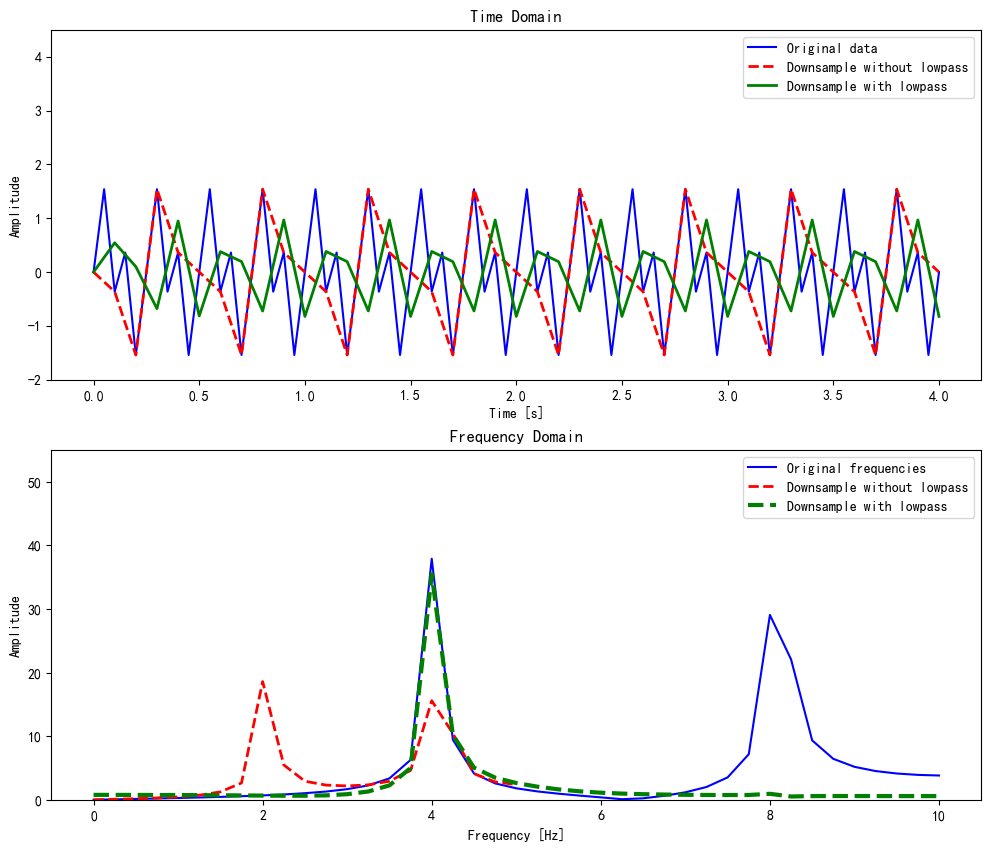

In [3]:
npts = 512                              # 样本数量
nsec = 4                                # 信号长度（以秒为单位）
sps = 20                                # 采样率
fre_nyq = sps / 2.0                     # 奈奎斯特频率
fre_8 = 8                               # 发生器频率1（初始值：8 Hz）
fre_4 = 4                               # 发生器频率2（初始值：4 Hz）
time = np.linspace(0,nsec,(nsec*sps)+1) # 绘图的时间轴

# 生成一个由两个频率组成的测试信号
single_data  = np.sin(2 * np.pi * fre_8 * time)   
single_data += np.sin(2 * np.pi * fre_4 * time) 

# 采样率降低到10Hz
single_resample = single_data[::2]

# 进行低通滤波处理后降采样
single_lowpass = lowpass(single_data, 5.0, df=sps, corners=4, zerophase=False)
single_lowpass_resample = single_lowpass[::2]

# 通过FFT应用傅里叶变换，将所有3个信号转换到频域 
y_f = np.fft.rfft(single_data)                    
y_f2 = np.fft.rfft(single_resample)                 
y_fnew = np.fft.rfft(single_lowpass)
freq = np.linspace(0, fre_nyq, len(y_f)) # 绘图所需的频率轴

# 绘图
plt.subplot(211)
plt.plot(time, single_data, 'b', label="Original data", lw=1.5)
plt.plot(time[::2], single_resample, 'r--', label="Downsample without lowpass", lw=2)
plt.plot(time[::2], single_lowpass_resample, 'g', label="Downsample with lowpass", lw=2)
plt.legend()
plt.ylim(-2, 4.5)
plt.title('Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(212)
plt.plot(freq, abs(y_f), 'b', label="Original frequencies", lw=1.5)
plt.plot(freq[:len(y_f2)], abs(y_f2), 'r--', label="Downsample without lowpass", lw=2)
plt.plot(freq[:len(y_fnew)], abs(y_fnew), 'g--', label="Downsample with lowpass", lw=3)
plt.legend()
plt.ylim(0, 55)
plt.title('Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.show()

### 3.重采样

***resample***

Original:100.0
Result:  20.0


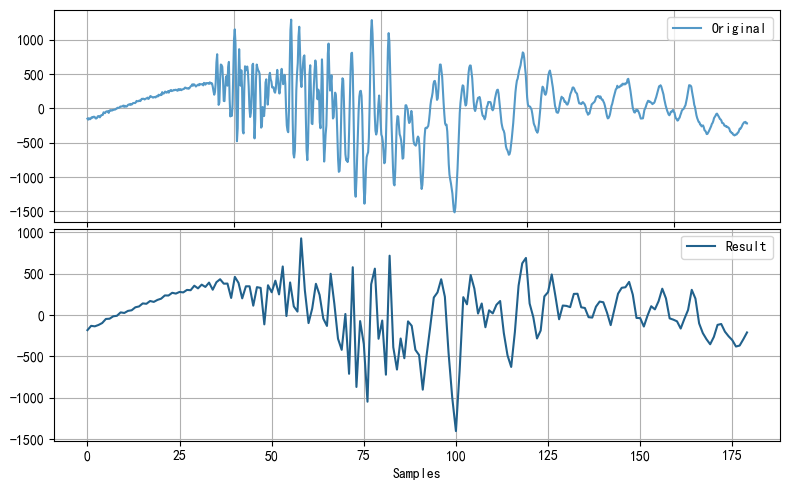

In [4]:
tr=read("../data/detrend_test_stream.mseed")[0]
tr = tr.slice(starttime=UTCDateTime("2009-08-24T00:20:06.000000Z"), endtime=UTCDateTime("2009-08-24T00:20:15.000000Z"))

tr_resample = tr.copy()
tr_resample.resample(sampling_rate=20, window="hann", no_filter=True, strict_length=False)

print("Original:" + str(tr.stats.sampling_rate))
print("Result:  " + str(tr_resample.stats.sampling_rate))

fig, ax = plt.subplots(2, 1, figsize=(8, 5))
plt.subplots_adjust(hspace=0)
ax[0].plot(tr.data, color="#5499C7", label="Original")
ax[0].legend(loc="best")
ax[0].label_outer()
ax[0].grid()
ax[1].plot(tr_resample.data, color="#21618C", label="Result")
ax[1].legend(loc="best")
ax[1].label_outer()
ax[1].set_xlabel("Samples")
ax[1].grid()

plt.tight_layout(h_pad=0)
plt.show()

***decimate***

Original:100.0
Result:  20.0


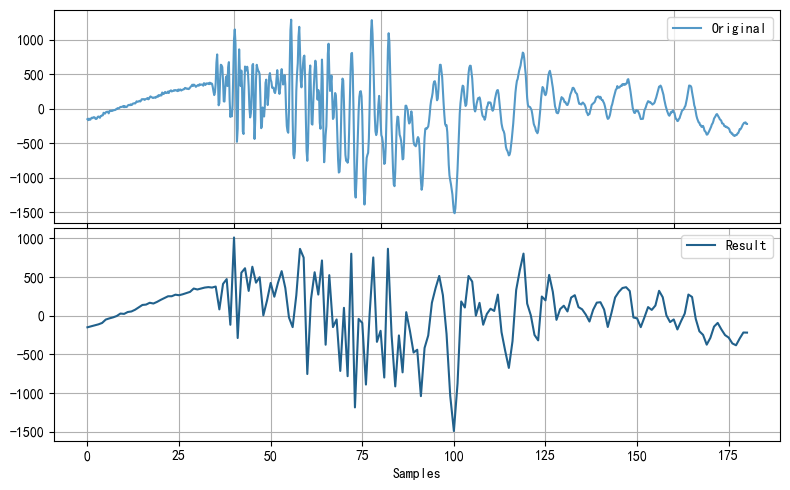

In [5]:
tr=read("../data/detrend_test_stream.mseed")[0]
tr = tr.slice(UTCDateTime("2009-08-24T00:20:06.000000Z"), UTCDateTime("2009-08-24T00:20:15.000000Z"))

tr_resample = tr.copy()
tr_resample.decimate(factor=5, no_filter=True, strict_length=False)

print("Original:" + str(tr.stats.sampling_rate))
print("Result:  " + str(tr_resample.stats.sampling_rate))

fig, ax = plt.subplots(2, 1, figsize=(8, 5))
plt.subplots_adjust(hspace=0)
ax[0].plot(tr.data, color="#5499C7", label="Original")
ax[0].legend(loc="best")
ax[0].label_outer()
ax[0].grid()
ax[1].plot(tr_resample.data, color="#21618C", label="Result")
ax[1].legend(loc="best")
ax[1].label_outer()
ax[1].set_xlabel("Samples")
ax[1].grid()

plt.tight_layout(h_pad=0)
plt.show()

***interpolate***

Original:100.0
Result:  20.0


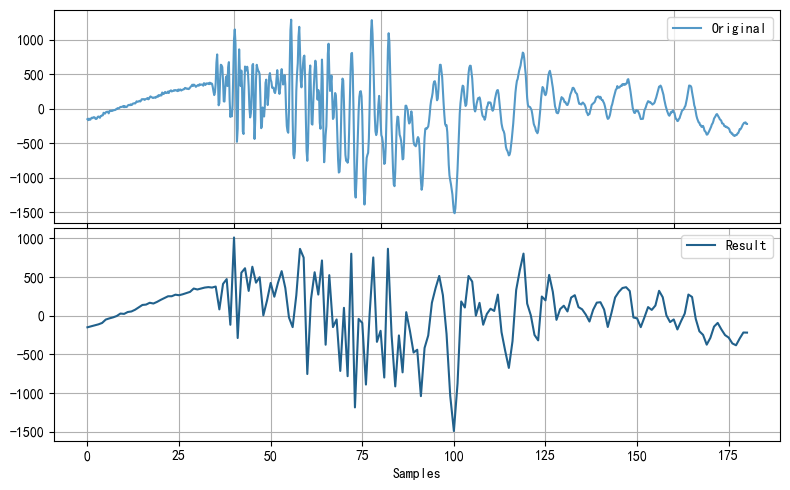

In [6]:
# linear | nearest | zero | slinear | quadratic | cubic | lanczos | weighted_average_slopes
tr = read("../data/detrend_test_stream.mseed")[0]
tr = tr.slice(UTCDateTime("2009-08-24T00:20:06.000000Z"), UTCDateTime("2009-08-24T00:20:15.000000Z"))

tr_resample = tr.copy()
tr_resample.interpolate(sampling_rate=20, method="slinear") 

print("Original:" + str(tr.stats.sampling_rate))
print("Result:  " + str(tr_resample.stats.sampling_rate))

fig, ax = plt.subplots(2, 1, figsize=(8, 5))
plt.subplots_adjust(hspace=0)
ax[0].plot(tr.data, color="#5499C7", label="Original")
ax[0].legend(loc="best")
ax[0].label_outer()
ax[0].grid()
ax[1].plot(tr_resample.data, color="#21618C", label="Result")
ax[1].legend(loc="best")
ax[1].label_outer()
ax[1].set_xlabel("Samples")
ax[1].grid()

plt.tight_layout(h_pad=0)
plt.show()